In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tslearn.metrics import dtw
from tslearn.utils import to_time_series
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
folder_name = 'cluster_timeseries/'

collected_data = ["2013-2024"]
#dtw_knn_2 -> datasetnya lebih besar
# https://code.earthengine.google.com/52607160b523092795f576172fb238b3

labeled_df = pd.read_csv(folder_name + "label_pandanwangi_ids.csv").drop([".geo", "system:index"], axis=1)
warungkondang_df = pd.read_csv(folder_name + "evi_warungkondang_2013_2024.csv").drop("system:index", axis=1)
cluster_geo = warungkondang_df[['cluster_id', '.geo']]
warungkondang_df = warungkondang_df.drop(".geo", axis=1)

In [4]:
labeled_df.groupby('label').count()

,cluster_id
label,
non-pandanwangi,35
pandanwangi,33


In [5]:
cluster_geo.head()

,cluster_id,.geo
0,864887829,"{""geodesic"":false,""type"":""MultiPolygon"",""coord..."
1,590686206,"{""geodesic"":false,""type"":""MultiPolygon"",""coord..."
2,-579235901,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."
3,34695210,"{""geodesic"":false,""type"":""MultiPolygon"",""coord..."
4,-1265565538,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."


In [6]:
columns = warungkondang_df.columns.tolist()
renamed_columns = []

for col in columns:
    colname = ""
    if "T48MYT" in col:
        colname = col.split("_")[3][:8]
    elif "LC08" in col:
        colname = col.split("_")[5]
    elif "LE07" in col:
        colname = col.split("_")[3]
    renamed_columns.append(colname)

renamed_columns = renamed_columns[:-1]

old_new_col = dict(zip(columns, renamed_columns))
# print(old_new_col)

In [7]:
warungkondang_df = warungkondang_df.rename(columns=old_new_col)
# print(warungkondang_df)
# menghapus kolom yg namanya duplikat
warungkondang_df = warungkondang_df.loc[:, ~warungkondang_df.columns.duplicated(keep='first')]

# mengurutkan kolom berdasarkan urutan tanggalnya
warungkondang_df = warungkondang_df.reindex(sorted(warungkondang_df.columns), axis=1)

warungkondang_df = warungkondang_df.ffill(axis=1)
warungkondang_df = warungkondang_df.bfill(axis=1)

In [8]:
labeled_df.shape

(68, 2)

In [9]:
warungkondang_labeled = warungkondang_df[warungkondang_df['cluster_id'].isin(labeled_df['cluster_id'])]
warungkondang_not_labeled = warungkondang_df[~warungkondang_df['cluster_id'].isin(labeled_df['cluster_id'])]

In [10]:
print("labeled data: " + str(warungkondang_labeled.shape))
print("non-labeled data: " + str(warungkondang_not_labeled.shape))

labeled data: (68, 2)
non-labeled data: (163, 2)


In [11]:
warungkondang_labeled = pd.merge(warungkondang_labeled, labeled_df, on='cluster_id', how='left')

X_wk = warungkondang_labeled.iloc[:, :-2]
y_wk = warungkondang_labeled['label']
print(X_wk.shape)

X_train, X_test, y_train, y_test = train_test_split(X_wk, y_wk, test_size=0.33, random_state=42, stratify=y_wk)

(68, 1)


In [15]:
def evaluate(y_test, y_pred):
    # Overall metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Get unique classes
    classes = np.unique(y_test)
    
    # Print overall metrics
    print("Overall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    print("\nPer-Class Metrics:")
    
    # Calculate and print per-class metrics
    precision_per_class = precision_score(y_test, y_pred, average=None, labels=classes)
    recall_per_class = recall_score(y_test, y_pred, average=None, labels=classes)
    f1_per_class = f1_score(y_test, y_pred, average=None, labels=classes)
    
    # Create a DataFrame for better display of per-class metrics
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1 Score': f1_per_class
    })
    
    # Display per-class metrics
    for i, cls in enumerate(classes):
        print(f"Class {cls}:")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  F1 Score: {f1_per_class[i]:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Also show classification report for a comprehensive view
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return metrics_df

In [27]:
# buat model KNN

constraint = "" # '' atau 'itakura' 'sakoe_chiba'
slope = 3
radius = 4

def dtw_distance(x, y):
    x_formatted = to_time_series(x)
    y_formatted = to_time_series(y) 
    dtw_score = dtw(x_formatted, y_formatted)
    if(constraint == 'itakura'):
        dtw_score = dtw(x_formatted, y_formatted, global_constraint="itakura", itakura_max_slope=slope)
    elif(constraint == 'sakoe_chiba'):
        dtw_score = dtw(x_formatted, y_formatted, global_constraint="sakoe_chiba", sakoe_chiba_radius=radius)
    return dtw_score


knn_pandanwangi = KNeighborsClassifier(n_neighbors = 5, metric=dtw_score)
knn_pandanwangi.fit(X_train, y_train)

y_pred = knn_1.predict(X_test)

Overall Metrics:
Accuracy: 0.6522
Weighted Precision: 0.7014
Weighted Recall: 0.6522
Weighted F1 Score: 0.6217

Per-Class Metrics:
Class non-pandanwangi:
  Precision: 0.6111
  Recall: 0.9167
  F1 Score: 0.7333
Class pandanwangi:
  Precision: 0.8000
  Recall: 0.3636
  F1 Score: 0.5000


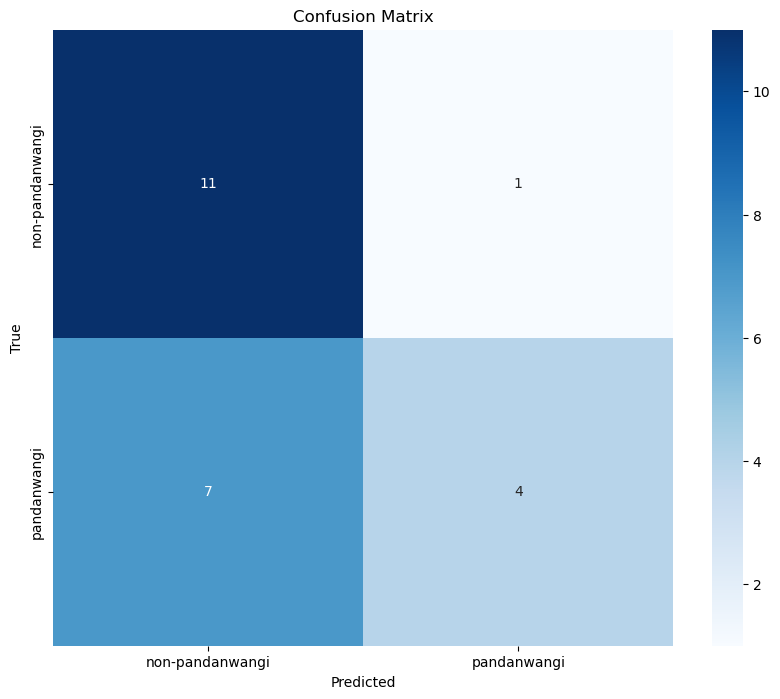


Classification Report:
                 precision    recall  f1-score   support

non-pandanwangi       0.61      0.92      0.73        12
    pandanwangi       0.80      0.36      0.50        11

       accuracy                           0.65        23
      macro avg       0.71      0.64      0.62        23
   weighted avg       0.70      0.65      0.62        23



,Class,Precision,Recall,F1 Score
0,non-pandanwangi,0.611111,0.916667,0.733333
1,pandanwangi,0.800000,0.363636,0.500000


In [28]:
evaluate(y_test, y_pred)

In [29]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}


# print(scoring)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stratified_cv_scores = cross_val_score(knn_1, X_wk, y_wk, cv=skf, scoring='accuracy')

print("\nStratified k-fold results:")
for i, score in enumerate(stratified_cv_scores):
    print(f"Fold {i+1}: {score:.4f}")

print(f"\nAverage accuracy (stratified): {np.mean(stratified_cv_scores):.4f}")
print(f"Standard deviation (stratified): {np.std(stratified_cv_scores):.4f}")


Stratified k-fold results:
Fold 1: 0.4286
Fold 2: 0.4286
Fold 3: 0.8571
Fold 4: 0.7143
Fold 5: 0.7143
Fold 6: 0.8571
Fold 7: 0.8571
Fold 8: 0.7143
Fold 9: 0.5000
Fold 10: 0.6667

Average accuracy (stratified): 0.6738
Standard deviation (stratified): 0.1601


In [15]:
#with larger dataset
final_model = KNeighborsClassifier(n_neighbors=5, metric=dtw_score)
final_model.fit(X_wk, y_wk)

pickle.dump(final_model, open(folder_name + 'saved_models/' + 'ts_classification.pkl', 'wb'))
pickle.dump(X_wk.columns, open(folder_name + 'saved_models/' + 'model_features.pkl', 'wb'))

predict_all = final_model.predict(warungkondang_not_labeled.iloc[:, :-1])
# print(predict_all)

In [16]:
unlabeled_df = warungkondang_not_labeled.copy()
unlabeled_df['label'] = predict_all
predicted_df = unlabeled_df.copy()

model_df = warungkondang_labeled.copy()

In [17]:
final_df = pd.concat([model_df, predicted_df], axis=0)
final_df.shape

(1277, 454)

In [20]:
evi = True
output_filename = "warungkondang" + ".csv"
if evi:
    output_filename = 'evi_' + output_filename
    
output_folder = 'classification_result/'

final_df.to_csv(folder_name + output_folder + output_filename)